In [1]:
import torch
import torch.nn as nn
import pandas
import nltk
from sklearn.model_selection import train_test_split
import numpy
from time import perf_counter

Check that GPU is available in colab. Change runtime in between and observe the difference.

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available():
  print(f"Number of GPUs: {torch.cuda.device_count()}")
  for i in range(torch.cuda.device_count()):
      print(f"\nGPU {i}:")
      print(f"  Name: {torch.cuda.get_device_name(i)}")
      print(f"  Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
      print(f"  MultiProcessor Count: {torch.cuda.get_device_properties(i).multi_processor_count}")
      print(f"  CUDA Capability: {torch.cuda.get_device_properties(i).major}.{torch.cuda.get_device_properties(i).minor}")

False


AssertionError: Torch not compiled with CUDA enabled

In Google Colab, pytorch automatically uses the T4 GPU specified in the runtime. The below code will come in handy when training the model on a bare metal node. We can specify the GPU and move the model/data to the GPU. Pytorch will then automatically execute operations on the GPU.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df = pandas.read_csv('/content/all-data.csv', encoding='ISO-8859-1', header=None, names=["Sentiment", "Headline"])
df.head()

,Sentiment,Headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


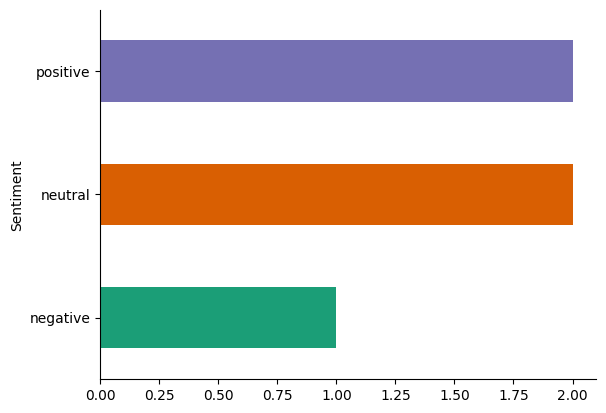

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
#lowercase
df['Headline'] = df['Headline'].str.lower()
df.info()

def remove_whitespaces(document):
  return " ".join(document.split())
df['Headline'] = df['Headline'].apply(remove_whitespaces)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4846 non-null   object
 1   Headline   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


,Sentiment,Headline
0,neutral,"according to gran , the company has no plans t..."
1,neutral,technopolis plans to develop in stages an area...
2,negative,the international electronic industry company ...
3,positive,with the new production plant the company woul...
4,positive,according to the company 's updated strategy f...


In [ ]:
nltk.download('punkt_tab')
from nltk import word_tokenize
df['Headline'] = df['Headline'].apply(lambda headline: word_tokenize(headline))

def categorize_sentiment(sentiment):
  if sentiment == 'positive':
    return 0
  elif sentiment == 'neutral':
    return 1
  elif sentiment == 'negative':
    return 2
  return 1

df['Label'] = df['Sentiment'].apply(lambda sentiment: categorize_sentiment(sentiment))
df.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,Sentiment,Headline,Label
0,neutral,"[according, to, gran, ,, the, company, has, no...",1
1,neutral,"[technopolis, plans, to, develop, in, stages, ...",1
2,negative,"[the, international, electronic, industry, com...",2
3,positive,"[with, the, new, production, plant, the, compa...",0
4,positive,"[according, to, the, company, 's, updated, str...",0


In [ ]:
#remove stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')

def remove_stopwords(document):
  result = []
  for token in document:
    if token not in english_stopwords:
      result.append(token)
  return result
df['Headline'] = df['Headline'].apply(remove_stopwords)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Sentiment,Headline,Label
0,neutral,"[according, gran, ,, company, plans, move, pro...",1
1,neutral,"[technopolis, plans, develop, stages, area, le...",1
2,negative,"[international, electronic, industry, company,...",2
3,positive,"[new, production, plant, company, would, incre...",0
4,positive,"[according, company, 's, updated, strategy, ye...",0


Now build the vocabulary (represents the feature space), create a wordToIdx dictionary so we can use it in our embeddings etc. Note we haven't used pretrained embeddings like glove here

In [ ]:
from collections import Counter
vocabulary = set()
for headline in df['Headline']:
  for word in headline:
    vocabulary.add(word)

vocab = Counter(vocabulary)
vocab = sorted(vocab, key=vocab.get, reverse=True)
vocab_size = len(vocab)

word2idx = {word: index for index, word in enumerate(vocab)} #create a mreverse mapping

def create_index_representation_for_headline(headline):
  return [word2idx[word] for word in headline]

df['Headline Indices'] = df['Headline'].apply(create_index_representation_for_headline)
df.head()

,Sentiment,Headline,Label,Headline Indices
0,neutral,"[according, gran, ,, company, plans, move, pro...",1,"[7051, 6254, 4011, 6792, 3040, 10839, 7286, 52..."
1,neutral,"[technopolis, plans, develop, stages, area, le...",1,"[4460, 3040, 9063, 11154, 8262, 1593, 6360, 10..."
2,negative,"[international, electronic, industry, company,...",2,"[2454, 11002, 11020, 6792, 3241, 10490, 6171, ..."
3,positive,"[new, production, plant, company, would, incre...",0,"[11513, 7286, 1748, 6792, 8641, 245, 10274, 95..."
4,positive,"[according, company, 's, updated, strategy, ye...",0,"[7051, 6792, 2387, 4783, 2161, 7695, 6743, 401..."


Split the dataset into training and test groups

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df['Headline Indices'], df['Label'], test_size=0.2)

X_train = numpy.array(X_train)
X_test = numpy.array(X_test)
y_train = numpy.array(Y_train)
y_test = numpy.array(Y_test)

In [ ]:
print(len(X_train[0]))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_train[0])
print(word2idx["beat"])
print(len(X_train[0]), len(X_train[200]))

9
(3876,) (3876,)
(970,) (970,)
[5527, 6818, 6999, 1901, 11255, 7805, 8447, 2333, 9540]
9430
9 14


Define the model. Using LSTM to encode the headline. Then piping in the last hidden state as the input to a feed forward neural network and performing classification.

In [ ]:
class EncoderDecoder(nn.Module):

  def __init__(self, embedding_dim, vocab_size, num_classes) -> None:
    super(EncoderDecoder, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim=embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, 50)

    self.linear = nn.Linear(50, num_classes)
    self.softmax = nn.Softmax(dim=0)
    self.logsoftmax = nn.LogSoftmax(dim = 0)

  def forward(self, headline):
    embeddings = self.embedding(headline)
    lstm_out = self.lstm(embeddings)
    encoded_lstm_out = lstm_out[0][0]

    linear = self.linear(encoded_lstm_out)
    logsoftmax = self.logsoftmax(linear)

    return logsoftmax


Noticed that torch.cuda.memory_allocated() was returning 0.0 MB in each epoch. This means the GPU is not being used for operations. We need to explicitly move the data/model over to the GPU. In the two subsequent cells we move the model to cuda and the training data to cuda.

In [ ]:
num_classes=3
model = EncoderDecoder(embedding_dim=100, vocab_size=vocab_size, num_classes=num_classes).to(device)
print(model)

EncoderDecoder(
  (embedding): Embedding(11576, 100)
  (lstm): LSTM(100, 50)
  (linear): Linear(in_features=50, out_features=3, bias=True)
  (softmax): Softmax(dim=0)
  (logsoftmax): LogSoftmax(dim=0)
)


In [ ]:
X_train_tensors = []
for headline_indicies in X_train:
  X_train_tensors.append(torch.tensor(headline_indicies, dtype=torch.long, device=device))
sample_row_output = model.forward(torch.tensor(X_train_tensors[0]))

<ipython-input-14-ec5041750daf>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_row_output = model.forward(torch.tensor(X_train_tensors[0]))


In [ ]:
print(len(X_train[0]))
print(sample_row_output[0].shape)
print(sample_row_output)
#print(sample_row_output[1][0].shape) used to log lstm output
# print(sample_row_output[1][1].shape)

19
torch.Size([])
tensor([-1.1387, -1.0345, -1.1259], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)


In [ ]:
# model training
from torch import optim
epochs = 8
optimizer = optim.Adam(model.parameters(), lr = 0.01)

start = perf_counter()
for x in range(epochs):

  total_loss = 0.0
  num_correct = 0

  for i in range(len(X_train_tensors)):

    headline = X_train_tensors[i]
    class_log_probs = model.forward(headline)

    y_onehot = torch.zeros(num_classes).to(device)
    correct_label = y_train[i]
    y_onehot[correct_label] = 1

    predicted_label = torch.argmax(class_log_probs)

    if (correct_label == predicted_label):
      num_correct += 1

    loss = torch.neg(class_log_probs).dot(y_onehot)
    total_loss += loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print('------------------------')
  print(f'Finished epoch {x}, loss equals {total_loss}')
  accuracy = num_correct / len(X_train)
  print(f'Training accuracy: {accuracy}')
  print(f"Allocated Memory: {torch.cuda.memory_allocated() / 1e6:.2f} MB")
  print(f"Cached Memory: {torch.cuda.memory_reserved() / 1e6:.2f} MB")
end = perf_counter()


------------------------
Finished epoch 0, loss equals 3623.143310546875
Training accuracy: 0.5900412796697626
Allocated Memory: 38.08 MB
Cached Memory: 67.11 MB
------------------------
Finished epoch 1, loss equals 3223.994873046875
Training accuracy: 0.6367389060887513
Allocated Memory: 38.08 MB
Cached Memory: 67.11 MB
------------------------
Finished epoch 2, loss equals 2989.823486328125
Training accuracy: 0.6741486068111455
Allocated Memory: 38.08 MB
Cached Memory: 67.11 MB
------------------------
Finished epoch 3, loss equals 2783.764892578125
Training accuracy: 0.6965944272445821
Allocated Memory: 38.08 MB
Cached Memory: 67.11 MB
------------------------
Finished epoch 4, loss equals 2656.088623046875
Training accuracy: 0.7027863777089783
Allocated Memory: 38.08 MB
Cached Memory: 67.11 MB
------------------------
Finished epoch 5, loss equals 2583.5908203125
Training accuracy: 0.7107843137254902
Allocated Memory: 38.08 MB
Cached Memory: 67.11 MB
------------------------
Finis

Training Execution Time With GPU. For context, the initial training time of the failed attempt on the CPU was 328 seconds.. I'm sure training could be parallelized to fully utilize all the CPU cores but that's not of interest here.

In [ ]:
print(f"Execution Time: {end - start} seconds")

Execution Time: 69.27808985599995 seconds


Test Accuracy

In [ ]:
X_test_tensors = []
for headline_indicies in X_test:
  X_test_tensors.append(torch.tensor(headline_indicies, dtype=torch.long, device=device))

In [ ]:
num_correct = 0
for i in range(len(X_test)):
  class_log_probs = model.forward(torch.tensor(X_test_tensors[i]))
  correct_label = y_test[i] - 1
  predicted_label = torch.argmax(class_log_probs)

  if(correct_label == predicted_label):
    num_correct += 1

test_accuracy = num_correct / len(X_test)
print(f'Test accuracy: {test_accuracy}')

<ipython-input-20-14d57a3b2e63>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_log_probs = model.forward(torch.tensor(X_test_tensors[i]))


Test accuracy: 0.16494845360824742


Save the model so we can use it later..

In [ ]:
lstm_ffnn = torch.save(model, 'lstm_ffnn.pt')
print('Model saved')

Model saved
